## LG AI 해커톤, 블럭 장난감 제조 공정 최적화 AI경진대회
## 대왕이 (팀명)
## 2020년 7월 3일 (제출날짜)

### 코드 제출 규칙

- 입상자는 데이콘에서 안내한 양식에 맞추어 코드 제출

- R user는 R or .rmd. Python user는 .py or .ipynb로 제출

- 코드에 ‘/data’ 데이터 입/출력 경로 포함

- 전체 프로세스를 가독성 있게 정리하여 주석 포함 하나의 파일로 제출

- 제출 코드는 리더보드 점수를 복원할 수 있어야 함

- 모든 코드는 오류 없이 실행되어야 함 (라이브러리 로딩 코드 포함)

- 코드와 주석의 인코딩은 UTF-8 사용

- AI 모델을 사용해야 함

* AI 모델 학습 과정이 있어야 함

* Gurobi, FICO 등 상용 솔루션 사용 불가

# 0. 분석 환경

CPU : Intel(R) Xeon(R) CPU E5-2630 0 @ 2.30GHz (24core)  
Memory : 65,943,312kb (64GB)  
pandas = 1.0.5  
numpy = 1.18.5  
matplotlib = 3.2.2  
python = 3.8.3

## 1. 라이브러리 및 데이터
## Library & Data

In [1]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
from copy import deepcopy
from module.genome import Genome, genome_score
import matplotlib.pyplot as plt
from module.simulator import Simulator
import time

warnings.filterwarnings(action='ignore')
np.random.seed(777)

## 2. 데이터 전처리
## Data Cleansing & Pre-Processing  

In [2]:
# "성형" 공정
df_max_count = pd.read_csv('../data/max_count.csv')
df_change_time = pd.read_csv('../data/change_time.csv')
# "자르기" 공정 
df_cut_yield = pd.read_csv('../data/cut_yield.csv')
# "계산에 필요한 파일
df_order = pd.read_csv('../data/order.csv')
df_stock = pd.read_csv('../data/stock.csv')
# 제출해야 할 파일
df_sample_submission = pd.read_csv('../data/sample_submission.csv')

## 3. 탐색적 자료분석
## Exploratory Data Analysis

* 원형 제작 PRT1, 2, 3, 4
* 성형 MOL1 2, 3, 4
* 자르기 BLK1, 2, 3, 4  
##### 성형공정
* max_count
date : 날짜  
count : 성형 공정 일별 최대 투입 개수 (A, B 라인 동일)
* change_time
from / to: from에서 to로 제품 변경  
time : 변경에 필요한 시간 (단위: 시간)  
##### 자르기공정
* cut_yield
date : 날짜  
BLK_1 ~ BLK_4 : 자르기 공정의 각 아이템 월별 양품률 (단위: %)  
##### 주문재고
* stock  
date : 구분자  
PRT_1 ~ BLK_4 : 2020.04.01 보유 각 아이템 재고
* order  
date : 구분자  
BLK_1 ~ BLK_4 : 블럭 장난감 일별 수요  
##### 제출파일
* sample_submission
time : 시간 (type: STRING)  
PRT_1 ~ PRT_4 : 원형 생산 투입 개수 (type: INT)  
Event_A : A 라인 성형 공정 이벤트 (type: STRING)  
Event_B : B 라인 성형 공정 이벤트 (type: STRING)  
PROCESS: 공정  
STOP: 멈춤  
CHECK: 점검, 점검 후 공정에 투입할 아이템 번호를 숫자로 구분. ex) 점검 후 PRT_2를 투입하는 경우 CHECK_2로 표현  
CHANGE: 성형 공정 아이템 변경, 변경 아이템 번호를 숫자로 구분. ex) 아이템이 MOL_3에서 MOL_2로 변경시 CHANGE_32로 표현  
MOL_A : A 라인 성형 공정 아이템 투입 개수 (type: FLOAT)  
MOL_B : B 라인 성형 공정 아이템 투입 개수 (type: FLOAT)  


In [3]:
print('max_count:', df_max_count.shape,
      '\nchange_time:', df_change_time.shape,
      
      '\ncut_yield:', df_cut_yield.shape,
      
      '\norder:', df_order.shape,
      '\nstock:', df_stock.shape,
      '\nsample_submission:', df_sample_submission.shape)

max_count: (91, 2) 
change_time: (12, 3) 
cut_yield: (3, 5) 
order: (91, 5) 
stock: (1, 12) 
sample_submission: (2184, 9)


In [4]:
df_max_count.tail(2)  # (91, 2)

,date,count
89,2020-06-29,141.018518
90,2020-06-30,141.018518


In [5]:
df_change_time.head(2)  # (12, 3)
# 1,2 or 3,4 끼리는 6시간 / 그외(1-3, 1-4, 2-3, 2-4)는 13시간

,from,to,time
0,MOL_1,MOL_2,6
1,MOL_1,MOL_3,13


In [6]:
df_cut_yield  # (3, 5)

,date,BLK_1,BLK_2,BLK_3,BLK_4
0,202004,85.1,90.1,71.0,70.0
1,202005,85.1,90.1,74.2,73.2
2,202006,85.1,90.1,75.9,74.9


In [7]:
df_order.tail(2)  # (91, 5)

,time,BLK_1,BLK_2,BLK_3,BLK_4
89,2020-06-29,42499,0,41941,31046
90,2020-06-30,42499,0,62911,0


In [8]:
# 필요한 MOL개수 대략적으로 살펴보기
onetwo = df_order[['BLK_1', 'BLK_2']]/506
threefour = df_order[['BLK_3', 'BLK_4']]/400
df_mol = pd.concat([df_order['time'], onetwo, threefour], axis=1)
df_mol.tail(2)

,time,BLK_1,BLK_2,BLK_3,BLK_4
89,2020-06-29,83.990119,0.0,104.8525,77.615
90,2020-06-30,83.990119,0.0,157.2775,0.000


In [9]:
df_stock  # (1, 12)

,PRT_1,PRT_2,PRT_3,PRT_4,MOL_1,MOL_2,MOL_3,MOL_4,BLK_1,BLK_2,BLK_3,BLK_4
0,0,258,0,0,1086,0,0,0,61158,87279,0,0


In [10]:
df_sample_submission.tail(2)

,time,PRT_1,PRT_2,PRT_3,PRT_4,Event_A,MOL_A,Event_B,MOL_B
2182,2020-06-30 22:00:00,0,0,0,0,CHECK_3,0,CHECK_3,0
2183,2020-06-30 23:00:00,0,0,0,0,CHECK_3,0,CHECK_3,0


## 4. 변수 선택 및 모델 구축
## Feature Engineering & Initial Modeling  

* Hyper parameter

In [11]:
CPU_CORE = multiprocessing.cpu_count() # 멀티프로세싱 CPU 사용 수

N_POPULATION = 50                      # 세대당 생성수
N_BEST = 5                             # 베스트 수
N_CHILDREN = 5                         # 자손 유전자 수
PROB_MUTATION = 0.5                    # 돌연변이
REVERSE = False                        # 배열 순서 (False: ascending order, True: descending order)
EPOCHS = 160                            # 반복 횟수

score_ini = 1e8                        # 초기 점수
input_length = 125                     # 입력 데이터 길이
output_length_1 = 5                    # Event (CHECK_1~4, PROCESS)
output_length_2 = 12                   # MOL(0~5.5, step:0.5)
h1 = 50                                # 히든레이어1 노드 수
h2 = 50                                # 히든레이어2 노드 수
h3 = 50                                # 히든레이어3 노드 수

* Initial Modeling

In [12]:
# genomes는 전체 유전자를 가지고 있는 리스트
# best_genomes는 좋은 유전자를 가지고 있는 리스트

# 각 객체들의 인스턴스 생성
genomes = []
for _ in range(N_POPULATION):
    genome = Genome(score_ini, input_length, output_length_1, output_length_2, h1, h2, h3)
    genomes.append(genome)
try:
    for i in range(N_BEST):
        genomes[i] = best_genomes[i]        
except:
    best_genomes = []
    for _ in range(N_BEST):
        genome = Genome(score_ini, input_length, output_length_1, output_length_2, h1, h2, h3)
        best_genomes.append(genome)

## 5. 모델 학습 및 검증
## Model Tuning & Evaluation

* Modeling

In [13]:
n_gen = 1
score_history = []
high_score_history = []
mean_score_history = []

start = time.time()
while n_gen <= EPOCHS:
    # CPU_CORE 개수만큼 multi processing. 하나의 리스트를 cpu_core개수만큼의 열을 가진 행렬로 reshape한 후, 병렬로 처리
    genomes = np.array(genomes)
    while len(genomes)%CPU_CORE != 0:
        genomes = np.append(genomes, Genome(score_ini, input_length, output_length_1, output_length_2, h1, h2, h3))
    genomes = genomes.reshape((len(genomes)//CPU_CORE, CPU_CORE))
    for idx, _genomes in enumerate(genomes):
        if __name__ == '__main__':
            pool = multiprocessing.Pool(processes=CPU_CORE)
            genomes[idx] = pool.map(genome_score, _genomes)  # 각 인스턴스의 score 계산
            pool.close()
            pool.join()
    genomes = list(genomes.reshape(genomes.shape[0]*genomes.shape[1]))
    genomes.sort(key=lambda x: x.score, reverse=REVERSE)
    
    # 유전자(인스턴스)들의 점수 기록
    s = 0 
    for i in range(N_BEST):
        s += genomes[i].score
    s /= N_BEST
    bs = genomes[0].score
    if best_genomes is not None:
        genomes.extend(best_genomes)
    genomes.sort(key=lambda x: x.score, reverse=REVERSE)
    
    score_history.append([n_gen, genomes[0].score])
    high_score_history.append([n_gen, bs])
    mean_score_history.append([n_gen, s])
    
    # 결과 출력
    print('EPOCH #%s\tHistory Best Score: %s\tBest Score: %s\tMean Score: %s' % (n_gen, genomes[0].score, bs, s))
    # 모델 업데이트
    best_genomes = deepcopy(genomes[:N_BEST])
    # CHILDREN 생성
    for i in range(N_CHILDREN):
        # 아무 유전자 a, b를 뽑은 후, 반씩 섞인 가중치 행렬 생성
        new_genome = deepcopy(best_genomes[0])
        a_genome = np.random.choice(best_genomes)
        b_genome = np.random.choice(best_genomes)
        
        for j in range(input_length):
            cut = np.random.randint(new_genome.w1.shape[1])
            new_genome.w1[j, :cut] = a_genome.w1[j, :cut]
            new_genome.w1[j, cut:] = b_genome.w1[j, cut:]
        for j in range(h1):
            cut = np.random.randint(new_genome.w2.shape[1])
            new_genome.w2[j, :cut] = a_genome.w2[j, :cut]
            new_genome.w2[j, cut:] = b_genome.w2[j, cut:]
        for j in range(h2):
            cut = np.random.randint(new_genome.w3.shape[1])
            new_genome.w3[j, :cut] = a_genome.w3[j, :cut]
            new_genome.w3[j, cut:] = b_genome.w3[j, cut:]
        for j in range(h3):
            cut = np.random.randint(new_genome.w4.shape[1])
            new_genome.w4[j, :cut] = a_genome.w4[j, :cut]
            new_genome.w4[j, cut:] = b_genome.w4[j, cut:]
        for j in range(input_length):
            cut = np.random.randint(new_genome.w5.shape[1])
            new_genome.w5[j, :cut] = a_genome.w5[j, :cut]
            new_genome.w5[j, cut:] = b_genome.w5[j, cut:]
        for j in range(h1):
            cut = np.random.randint(new_genome.w6.shape[1])
            new_genome.w6[j, :cut] = a_genome.w6[j, :cut]
            new_genome.w6[j, cut:] = b_genome.w6[j, cut:]
        for j in range(h2):
            cut = np.random.randint(new_genome.w7.shape[1])
            new_genome.w7[j, :cut] = a_genome.w7[j, :cut]
            new_genome.w7[j, cut:] = b_genome.w7[j, cut:]
        for j in range(h3):
            cut = np.random.randint(new_genome.w8.shape[1])
            new_genome.w8[j, :cut] = a_genome.w8[j, :cut]
            new_genome.w8[j, cut:] = b_genome.w8[j, cut:]
        best_genomes.append(new_genome)
    # 모델 초기화
    genomes = []
    for i in range(int(N_POPULATION / len(best_genomes))):
        for bg in best_genomes:
            new_genome = deepcopy(bg)
            mean = 0
            stddev = 0.2
            # 돌연변이 생성
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w1 += new_genome.w1 * np.random.normal(mean, stddev, size=(input_length, h1)) * np.random.randint(0, 2, (input_length, h1))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w2 += new_genome.w2 * np.random.normal(mean, stddev, size=(h1, h2)) * np.random.randint(0, 2, (h1, h2))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w3 += new_genome.w3 * np.random.normal(mean, stddev, size=(h2, h3)) * np.random.randint(0, 2, (h2, h3))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w4 += new_genome.w4 * np.random.normal(mean, stddev, size=(h3, output_length_1)) * np.random.randint(0, 2, (h3, output_length_1))                
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w5 += new_genome.w5 * np.random.normal(mean, stddev, size=(input_length, h1)) * np.random.randint(0, 2, (input_length, h1))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w6 += new_genome.w6 * np.random.normal(mean, stddev, size=(h1, h2)) * np.random.randint(0, 2, (h1, h2))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w7 += new_genome.w7 * np.random.normal(mean, stddev, size=(h2, h3)) * np.random.randint(0, 2, (h2, h3))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w8 += new_genome.w8 * np.random.normal(mean, stddev, size=(h3, output_length_2)) * np.random.randint(0, 2, (h3, output_length_2))
            genomes.append(new_genome)
    if REVERSE:
        if bs < score_ini:
            genomes[len(genomes)//2:] = [Genome(score_ini, input_length, output_length_1, output_length_2, h1, h2, h3) for _ in range(N_POPULATION//2)]
    else:
        if bs > score_ini:
            genomes[len(genomes)//2:] = [Genome(score_ini, input_length, output_length_1, output_length_2, h1, h2, h3) for _ in range(N_POPULATION//2)]  
    n_gen += 1
print('time:', time.time() - start)

EPOCH #1	History Best Score: 60448827.0	Best Score: 60448827.0	Mean Score: 72045590.6
EPOCH #2	History Best Score: 60448827.0	Best Score: 68156874.0	Mean Score: 69095127.4
EPOCH #3	History Best Score: 54902130.0	Best Score: 54902130.0	Mean Score: 64843827.2
EPOCH #4	History Best Score: 45893911.0	Best Score: 45893911.0	Mean Score: 56589759.8
EPOCH #5	History Best Score: 45893911.0	Best Score: 55189360.0	Mean Score: 57735583.0
EPOCH #6	History Best Score: 45893911.0	Best Score: 50058564.0	Mean Score: 52909843.8
EPOCH #7	History Best Score: 45893911.0	Best Score: 53806360.0	Mean Score: 57759270.8
EPOCH #8	History Best Score: 45893911.0	Best Score: 48853503.0	Mean Score: 52429100.0
EPOCH #9	History Best Score: 45893911.0	Best Score: 54506509.0	Mean Score: 59566668.8
EPOCH #10	History Best Score: 45893911.0	Best Score: 48126235.0	Mean Score: 57519292.8
EPOCH #11	History Best Score: 45893911.0	Best Score: 45893911.0	Mean Score: 50617006.4
EPOCH #12	History Best Score: 45893911.0	Best Score:

EPOCH #96	History Best Score: 39904231.0	Best Score: 41305141.0	Mean Score: 42799340.0
EPOCH #97	History Best Score: 39904231.0	Best Score: 41190600.0	Mean Score: 43117859.0
EPOCH #98	History Best Score: 39904231.0	Best Score: 45798594.0	Mean Score: 48042992.0
EPOCH #99	History Best Score: 39904231.0	Best Score: 43011427.0	Mean Score: 47434806.2
EPOCH #100	History Best Score: 39904231.0	Best Score: 48134835.0	Mean Score: 48514577.6
EPOCH #101	History Best Score: 39904231.0	Best Score: 43931296.0	Mean Score: 45714473.2
EPOCH #102	History Best Score: 39904231.0	Best Score: 42151968.0	Mean Score: 45228465.6
EPOCH #103	History Best Score: 39904231.0	Best Score: 39904231.0	Mean Score: 45269524.6
EPOCH #104	History Best Score: 39904231.0	Best Score: 48169188.0	Mean Score: 49365794.8
EPOCH #105	History Best Score: 39904231.0	Best Score: 44631059.0	Mean Score: 46395226.2
EPOCH #106	History Best Score: 39904231.0	Best Score: 40475412.0	Mean Score: 43833660.6
EPOCH #107	History Best Score: 39904

## 6. 결과 및 결언
## Conclusion & Discussion

# 결과

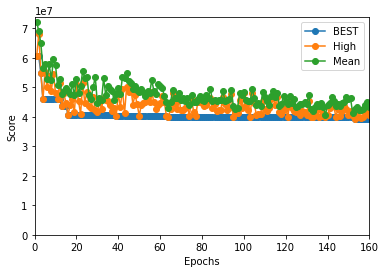

In [14]:
# Score Graph
score_history = np.array(score_history)
high_score_history = np.array(high_score_history)
mean_score_history = np.array(mean_score_history)

plt.plot(score_history[:,0], score_history[:,1], '-o', label='BEST')
plt.plot(high_score_history[:,0], high_score_history[:,1], '-o', label='High')
plt.plot(mean_score_history[:,0], mean_score_history[:,1], '-o', label='Mean')
plt.legend()
plt.xlim(0, EPOCHS)
plt.ylim(bottom=0)
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.show()

* Submission 파일 만들기

In [15]:
# 재고 계산
simulator = Simulator()
order = pd.read_csv('../data/order.csv')
submission = best_genomes[0].predict(order)
_, df_stock = simulator.get_score(submission)

# PRT 개수 계산
PRTs = df_stock[['PRT_1', 'PRT_2', 'PRT_3', 'PRT_4']].values
PRTs = (PRTs[:-1] - PRTs[1:])[24*23:]
PRTs = np.ceil(PRTs * 1.1)
PAD = np.zeros((24*23+1, 4))
PRTs = np.append(PRTs, PAD, axis=0).astype(int)

# Submission 파일에 PRT 입력
submission.loc[:, 'PRT_1':'PRT_4'] = PRTs
submission.to_csv('submission.csv', index=False)

# Custimize Check Score

In [16]:
# 나의 점수는?
from module.simulator_score import Simulator

scoring = Simulator()
whatthe, _ = scoring.get_score(submission)

print(whatthe)

87.96103724544044
